<h1 align="center">INTRODUCTION TO REGRESSION ANALYSIS</h1>
<h2 align="left"><ins>Lesson Guide</ins></h2>

- [**BASELINE PREDICTIONS**](#baseline)
- [**WHAT IS LINEAR REGRESSION?**](#linear)
	- [**Graphical Analysis of Variables**](#graphs)
    - [**Why Linear Regression is Important**](#importance)
    - [**Properties of SLR**](#properties)
    - [**Finding the "Best" Slope and Intercept**](#best)
    - [**What To Look For In Regression Model Output**](#look)
        - [**Standard Error of the Regression**](#ssr)
        - [**Adjusted R-squared**](#adjust)
        - [**Significance of the estimated coefficients**](#significance)
        - [**Values of the estimated coefficients**](#values)
        - [**Plots of Forecasts and Residuals**](#plots)
        - [**Out-of-sample Validation**](#sample)
    - [**What’s a good value for R-squared?**](#r_square)
    - [**What's the bottom line? How to Compare Models**](#compare)
    - [**Linear Regression Assumptions**](#assumptions)
    - [**Checking for Violations of the Assumptions**](#violations)
    - [**Key Assumptions of Effective Linear Regression**](#keys)
- [**EXAMPLE: Calculate Slope and Intercept Coefficients By Hand**](#hand)  
- [**EXAMPLE: Sacramento Real Estate Data**](#sacramento)
- [**RESOURCES**](#resource)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id="baseline"></a>
## BASELINE PREDICTIONS

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb that can be used as a "**baseline model**." 

A baseline is a method that uses heuristics, simple summary statistics, randomness, or machine learning to create predictions for a dataset. You can use these predictions to measure the baseline's performance (e.g., accuracy) -- this metric will then become what you compare any other machine learning algorithm against.

Besides using the mean or the value counts as a baseline model, we can also use [scikit learn](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) to perform this for both classification and regression problems. 

**`DummyClassifier`** for classification baselines
- **stratified** generates random predictions by respecting the training set class distribution.
- **most_frequent** always predicts the most frequent label in the training set.
- **prior** always predicts the class that maximizes the class prior (like most_frequent) and `predict_proba` returns the class prior.
- **uniform** generates predictions uniformly at random.
- **constant** always predicts a constant label that is provided by the user. 

A major motivation of this method is F1-scoring, when the positive class is a minority.

**`DummyRegressor`** for regression baselines
- **mean** always predicts the mean of the training targets.
- **median** always predicts the median of the training targets.
- **quantile** always predicts a user provided quantile of the training targets.
- **constant** always predicts a constant value that is provided by the user.

>**Note that with all these strategies, the predict method completely ignores the input data**

Let's look at a couple of examples to gain a better understaing.

In [2]:
# time spent in sport (hrs)
x = np.array([2,4,8,6,1,4,3,6,0,1])

# scores in a test
y = np.array([41, 59,  7, 24, 74, 28, 40, 29, 78, 55])

# Method 1 - converting data into a dictionary
# d = {'Play_sport(hrs)':x,'Test_scores':y}
# df = pd.DataFrame(data=d)

# Method 2 - joining 2 dataframes
# df1 = pd.DataFrame(x, columns=['Play_sport(hrs)'])
# df2 = pd.DataFrame(y, columns=['Test_scores'])
# df = df1.join(df2)

# Method 3 - this method only works if we transpose the data first
# df = pd.DataFrame(data=[x,y]).T
# df.columns = ['Play_sport(hrs)','Test_scores']

# Method 4 - applying numpy's horizontal stack method
# df = pd.DataFrame(data=np.hstack((x[:,None],y[:,None])),
#                   columns = ['Play_sport(hrs)','Test_scores'])

# Method 5 - starting with an empty dataframe
df = pd.DataFrame()
df['Play_sport(hrs)'] = x
df['Test_scores'] = y

df.head(2)

,Play_sport(hrs),Test_scores
0,2,41
1,4,59


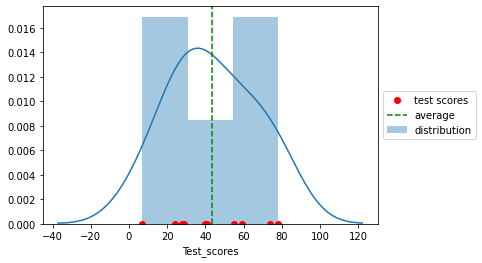

In [3]:
# distribution plot of the test scores (the blue bars and blue line)
sns.distplot(df['Test_scores'], label='distribution')

# plotting the test scores along the x-axis (the red dots)
plt.plot(df['Test_scores'], np.zeros_like(y), 'o', color='r', label='test scores')

# plotting the mean test score horizontally (green dashed line)
plt.axvline(np.mean(df['Test_scores']),linestyle='--',color='g', label='average')

# putting the labels outside the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In the following illustration, we can see that the red line is the baseline model being compared to the the blue line (the regression line).

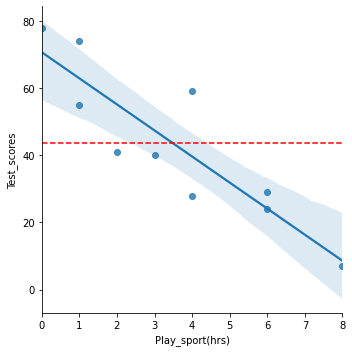

In [4]:
sns.lmplot(data=df, x='Play_sport(hrs)', y='Test_scores')

plt.axhline(df['Test_scores'].mean(), color='r', ls='--')

In this example, using the Iris dataset from sklearn, we can see that the baseline accuracy is around 60% while the SVC model's accuracy was improved to 95%. 

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [6]:
X, y = load_iris(return_X_y=True)
y[y != 1] = -1    # this is done to create an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf_base = DummyClassifier(strategy='most_frequent', random_state=0)
clf_base.fit(X_train, y_train)
print(f"Baseline score is: {clf_base.score(X_test, y_test)}")

clf_model1 = SVC(kernel='linear', C=1).fit(X_train, y_train)
clf_model1.score(X_test, y_test)
print(f"SVC score is: {clf_model1.score(X_test, y_test)}")

clf_model2 = SVC(kernel='rbf', C=1).fit(X_train, y_train)
clf_model2.score(X_test, y_test)
print(f"SVC score is: {clf_model2.score(X_test, y_test)}")

Baseline score is: 0.5789473684210527
SVC score is: 0.631578947368421
SVC score is: 0.9473684210526315


When the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

$\sum{[Actual(y) - Predicted(y)]^2}$

<a id="linear"></a>
## WHAT IS LINEAR REGRESSION?
Linear regression analysis is the most widely used of all statistical techniques: it is the study of linear, additive relationships between variables. It is one of the easiest algorithms to learn yet requires understanding and effort to master it.

Linear regression analysis is used to predict the value of a target variable (the dependent variable) based on the value of a feature variable (the independent variable). This form of analysis estimates the coefficients of the linear equation, involving one or more independent variables that best predict the value of the dependent variable. Linear regression fits a straight line or surface that minimizes the discrepancies between predicted and actual output values. To do this, regression uses a technique known as Ordinary Least Squares (OLS), which tries to reduce the sum of squared errors $\sum{[Actual(y) - Predicted(y)]^2}$ by finding the best possible value of regression coefficients ($\beta_{1}, \beta_{2},$ etc). By using the squared error approach, OLS has nice mathematical properties, thereby making it easier to differentiate and compute gradient descent. With this best-fit line we can then estimate the value of Y (dependent variable) from X (independent variable).

Regression is a parametric technique used to predict the value of an outcome variable Y based on one or more input predictor variables X. It is parametric in nature because it makes certain assumptions based on the data set. If the data set follows those assumptions, regression gives incredible results. Otherwise, it struggles to provide convincing accuracy.

The term "linear" here means linear in the coefficient. That means that we expect $Y$ to change by a constant amount for a constant change in $X$. A linear regression model could also include $X^2$, $X^3$, $log(X)$, etc., as long as the coefficients are linear.

<a id='graphs'></a>
### <ins>Graphical Analysis of variables</ins>
Before modeling regression and plotting the regression line, we need to understand the independent variables (predictors) and the dependent variable. The best way to do this is through visualizing their behavior:

- **Scatter plot:** helps to visualize any linear relationship between the dependent (response) variable and independent (predictor) variables. Ideally, we have multiple predictor variables, a scatter plot is drawn for each one of them against the response variable.

- **Box plot:** helps to spot any outlier observations in the variable. Having outliers in our predictor can drastically affect the predictions as they can easily affect the direction/slope of the line of best fit.

- **Density plot:** checks if the response variable is close to normality and sees the distribution of the predictor variable. Ideally, a close to a normal distribution (a bell-shaped curve), without being skewed to the left or right is preferred.

- **Correlation:** is a statistical measure that suggests the level of linear dependence between two variables, that occur in a pair. It can take values between -1 to +1. Correlation between two variables will be closer to 1 if there is a high positive relationship. The opposite is true for an inverse relationship, in which case, the correlation between the variables will be close to -1. A value closer to 0 suggests a weak relationship between the variables. A low correlation (-0.2 < x < 0.2) probably suggests that much of the variation of the response variable (Y) is unexplained by the predictor (X), in which case, we should probably look for better explanatory variables. Covariance provides a measure of the strength of the correlation between two or more sets of random variates.

<a id='importance'></a>
### <ins>Why Linear Regression is Important</ins>
Linear regression models are relatively simple and provide an easy-to-interpret mathematical formula that can generate predictions. Linear regression can be applied to various areas in business and academic study. Linear regression models have become a proven way to scientifically and reliably predict the future. Because linear regression is a long-established statistical procedure, the properties of linear-regression models are well understood and can be trained very quickly.

Business and organizational leaders can make better decisions by using linear regression techniques. Organizations collect masses of data, and linear regression helps them use that data to better manage reality — instead of relying on experience and intuition. You can take large amounts of raw data and transform it into actionable information. You can also use linear regression to provide better insights by uncovering patterns and relationships that may have gone unnoticed or not fully understood. For example, performing an analysis of sales and purchase data can help you uncover specific purchasing patterns on particular days or at certain times. Insights gathered from regression analysis can help business leaders anticipate times when their company’s products will be in high demand.

<a id='properties'></a>
### <ins>Properties of SLR</ins>

The simple linear regression estimators have really nice properties:
1. They are unbiased. (a.k.a. the statistics will on average equal the true parameter value)
2. Among all unbiased estimators, the estimators above have the smallest possible variance.
3. They are consistent. (a.k.a. as your sample size n goes to infinity, the statistic converges to the true parameter value)

**However, these are just mathematical properties.** They do not take into account real-world situations. When building a model, make sure the model makes sense. You are responsible for the interpretation of the model. All the computer will do is optimize. You may not do anything wrong when you fit a model, but make a note that there are shortcomings to the framework.

If all the assumptions hold true then: 
### $$ \hat{Y}_i \text{ ~ } N(\beta_0 + \beta_1 X_i, \sigma) $$

<a id='best'></a>
### <ins>Finding the "Best" Slope and Intercept</ins>

A linear regression is a linear approximation of a causal relationship between two or more variables. **The term "regression modeling" implies that the target variable (also known as the "dependent" variable and many other names) is a CONTINUOUS random variable.**
### $$Y = \beta_0 +\beta_1X$$
In this case, we don't know anything about the relationship between $X$ and $Y$. If we decided to plot the relationship between these variables on a graph, we wouldn't know where to start because we don't know how $X$ and $Y$ are related. (Another way of saying this is that we don't know $\beta_0$ or $\beta_1$.)

The line we want to plot for $Y$ as a function of $X$ is parameterized by its slope $\beta_1$ and Y-intercept $\beta_0$.

- $\beta_1$ is the **slope**. Its value indicates that, if $X$ were to increase by 1 unit, then $Y$ will increase by exactly $\beta_1$ units.

- $\beta_0$ is the **Y-intercept**. Its value indicates that, if $X$ equals 0, then Y is exactly equal to $\beta_0$ units. 

> *Warning: This is exact only if we know that $X$ and $Y$ have exactly a linear relationship. In almost all linear regression applications, this will not be exact!*

In simple linear regression (SLR), we model the inexact linear relationship between a single $X$ and $Y$ variable. We derive the slope and intercept from the data that "best fits" the data. We no longer require the relationship between X and Y to be exactly linear. It is assumed there will be some degree of *error* in our estimation. We understand and accept that errors in our data collection process and in the data itself will exist.

We now add a term for the *error*, denoted $\epsilon$:
### $$Y = \beta_0 +\beta_1X + \epsilon $$

**By adding a term for error, we are accounting for the fact that there may not be an exact function of $Y$ given $X$, $\beta_0$, and $\beta_1$.**

**If we want to find the "best" slope and intercept, we will need a criterion that defines what it means to be the "best". We also need to be able to numerically optimize (maximize or minimize) this criterion.**

- **Residuals**<br>
The difference between the true value of $Y$ and the predicted value of $Y$ (denoted $\hat{Y}$, "Y-hat") is known as a "residual." For every value of $\hat{Y}_i$, there is an accompanying residual $\epsilon_i$.


- **Residual sum of squares (RSS)**<br>
The most common way to define the "best fit line" is one that ensures our residuals (a.k.a. errors) will be as close to zero as possible. In fact, we see to minimize the *sum of squared residuals* or [residual sum of squares (RSS)](https://en.wikipedia.org/wiki/Residual_sum_of_squares). This minimizes the [mean squared error (MSE) or sum of squares of error (SSE)](https://en.wikipedia.org/wiki/Mean_squared_error).
### $$RSS = \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 $$
This is also known as a **loss function**, where the "loss" here is the sum of squared residuals.


- **Minimizing the MSE**<br>
### $$MSE = \frac{1}{n}\sum_{i=1}^n (Y_i - \hat{Y}_i)^2$$

Given variables:
- $\bar{y}$ : the sample mean of observed values $Y$
- $\bar{x}$ : the sample mean of observed values $X$
- $s_Y$ : the sample standard deviation of observed values $Y$
- $s_X$ : the sample standard deviation of observed values $X$
- $r_{XY}$ : the sample Pearson correlation coefficient between observed $X$ and $Y$

The equations for the intercept and slope that minimize the RSS is:
### $$ \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} \\
\hat{\beta}_1 = r_{XY} \frac{s_Y}{s_X}$$

<img src="./images/Linear Regression/anatomy of errors.png" width=600 height=600>

<a id='look'></a>
### <ins>What To Look For In Regression Model Output</ins>

<a id='ssr'></a>
$\;\;\;\;$**A. Standard Error of the Regression (root-mean-squared error adjusted for degrees of freedom)**<br>
Does the current regression model yield smaller errors, on average, than the best model previously fitted, and is the improvement significant in practical terms? In regression modeling, the best single error statistic to look at is the standard error of the regression, which is the estimated standard deviation of the unexplainable variations in the dependent variable. (It is approximately the standard deviation of the errors, apart from the degrees-of-freedom adjustment.) This is what is minimized when estimating coefficients, and it is a sufficient statistic for describing properties of the errors if the model’s assumptions are all correct. 

Furthermore, the standard error of the regression is a lower bound on the standard error of any forecast generated from the model. In general the forecast standard error will be a little larger because it also takes into account the errors in estimating the coefficients and the relative extremeness of the values of the independent variables for which the forecast is being computed. If the sample size is large and the values of the independent variables are not extreme, the forecast standard error will be only slightly larger than the standard error of the regression. 

**You should directly compare the standard error of the regression between models only if their units are the same and they are fitted to the same (or almost the same) sample of the same dependent variable.**

In time series forecasting, it is common to look not only at root-mean-squared error but also the **mean absolute error (MAE)** and, for positive data, the **mean absolute percentage error (MAPE)** in evaluating and comparing model performance. The latter measures are easier for non-specialists to understand and they are less sensitive to extreme errors, if the occasional big mistake is not a serious concern. Also, it is sometimes appropriate to compare MAPE between models fitted to different samples of data, because it is a relative rather than absolute measure. 

Whenever you are working with time series data, you should also ask:  does the current regression model improve on the best naive (random walk or random trend) model, according to these error measures? The **mean absolute scaled error** statistic measures improvement in mean absolute error relative to a random-walk-without-drift model. And how has the model been doing lately? Are its most recent errors typical in size and random-looking, or are they getting bigger or more biased?

<a id='adjust'></a>
$\;\;\;\;$**B. Adjusted R-squared**<br>
This is R-squared (the fraction by which the variance of the errors is less than the variance of the dependent variable) adjusted for the number of coefficients in the model relative to the sample size in order to correct it for bias (the same adjustment used in computing the standard error of the regression). That is, adjusted R-squared is the fraction by which the square of the standard error of the regression is less than the variance of the dependent variable. It is the most over-used and abused of all statistics--don't get obsessed with it. R-squared is not the bottom line. All it measures is the percentage reduction in mean-squared-error that the regression model achieves relative to the naive model "Y=constant", which may or may not be the appropriate naive model for purposes of comparison. Better to determine the best naive model first, and then compare the various error measures of your regression model (both in the estimation and validation periods) against that naive model.

Despite the fact that adjusted R-squared is a unitless statistic, there is no absolute standard for what is a "good" value. A regression model fitted to non-stationary time series data can have an adjusted R-squared of 99% and yet be inferior to a simple random walk model. On the other hand, a regression model fitted to stationarized time series data might have an adjusted R-squared of 10%-20% and still be considered useful (although out-of-sample validation would be advisable). A designed experiment looking for small but statistically significant effects in a very large sample might accept even lower values. 

<a id='significance'></a>
$\;\;\;\;$**C. Significance of the Estimated Coefficients**<br>
Are the t-statistics greater than 2 in magnitude, corresponding to p-values less than 0.05? If they are not, you should probably try to refit the model with the least significant variable excluded, which is the "backward stepwise" approach to model refinement. 

Remember that the t-statistic is just the estimated coefficient divided by its own standard error. Thus, it measures "how many standard deviations from zero" the estimated coefficient is, and it is used to test the hypothesis that the true value of the coefficient is non-zero, in order to confirm that the independent variable really belongs in the model.

The p-value is the probability of observing a t-statistic that large or larger in magnitude given the null hypothesis that the true coefficient value is zero. If the p-value is greater than 0.05--which occurs roughly when the t-statistic is less than 2 in absolute value--this means that the coefficient may be only "accidentally" significant. There's nothing magical about the 0.05 criterion, but in practice it usually turns out that a variable whose estimated coefficient has a p-value of greater than 0.05 can be dropped from the model without affecting the error measures very much.

<a id='values'></a>
$\;\;\;\;$**D. Values of the Estimated Coefficients**<br>
In general you are interested not only in the statistical significance of an independent variable, you are also interested in its practical significance. What does it imply in real terms? What have you learned, and how should you spend your time or money? In theory, the coefficient of a given independent variable is its proportional effect on the average value of the dependent variable, others things being equal. In business and weapons-making, this is often called "bang for the buck". Such information can be very useful for decision-making if some of the independent variables are under your control, for example, the amount of a drug administered to a patient, the price of a product, or the amount of money spent on promoting it. *Keep in mind that when sample sizes are very large, an effect that is really quite tiny (say, the marginal benefit of an expensive new medical treatment) could appear to be quite large if all you look at is its t-statistic.*

In some cases the interesting hypothesis is not whether the value of a certain coefficient is equal to zero, but whether it is equal to some other value. For example, if one of the independent variables is merely the dependent variable lagged by one period (i.e., an autoregressive term), then the interesting question is whether its coefficient is equal to one. If so, then the model is effectively predicting the difference in the dependent variable, rather than predicting its level, in which case you can simplify the model by differencing the dependent variable and deleting the lagged version of itself from the list of independent variables.

Sometimes patterns in the magnitudes and signs of lagged variables are of interest. For example if both X and LAG(X,1) are included in the model, and their estimated coefficients turn out to have similar magnitudes but opposite signs, this suggests that they could both be replaced by a single DIFF(X) term.

<a id='plots'></a>
$\;\;\;\;$**E. Plots of Forecasts and Residuals**<br>
DO NOT FAIL TO LOOK AT PLOTS OF THE FORECASTS AND ERRORS. Do the forecasts "track" the data in a satisfactory way, apart from the inevitable regression-to-the mean? (In the case of time series data, you are especially concerned with how the model fits the data at the "business end", i.e., the most recent values. Do the residuals appear random, or do you see some systematic patterns in their signs or magnitudes?  Are they free from trends, autocorrelation, and heteroscedasticity? Are they normally distributed? There are a variety of statistical tests for these sorts of problems, but the best way to determine whether they are present and whether they are serious is to look at the pictures.

If heteroscedasticity and/or non-normality is a problem, you may wish to consider a nonlinear transformation of the dependent variable, such as logging or deflating, if such transformations are appropriate for your data. (Remember that logging converts multiplicative relationships to additive relationships, so that when you log the dependent variable, you are implicitly assuming that the relationships among the original variables are multiplicative.)

If autocorrelation is a problem, you should probably consider changing the model so as to implicitly or explicitly include lagged variables--e.g., try stationarizing the dependent and independent variables via differencing, or add lags of the dependent and/or independent variables to the regression equation, or introduce an autoregressive error correction. 

You do not usually rank (i.e., choose among) models on the basis of their residual diagnostic tests, but bad residual diagnostics indicate that the model's error measures may be unreliable and that there are probably better models out there somewhere. 

<a id='sample'></a>
$\;\;\;\;$**F. Out-of-sample Validation**<br>
If you have enough data to hold out a sizable portion for validation and if your software offers this feature, you should compare the performance of the models in the validation as well as estimation periods. A good model should have small error measures in both the estimation and validation periods, compared to other models, and its validation period statistics should be similar to its own estimation period statistics. Regression models with many independent variables are especially susceptible to overfitting the data in the estimation period, so watch out for models that have suspiciously low error measures in the estimation period and disappointingly high error measures in the validation period.

If the variance of the errors in original, untransformed units is growing over time due to inflation or compound growth, then the best statistic to use for comparisons between the estimation and validation period is mean absolute percentage error, rather than mean squared error or mean absolute error.

Although the model's performance in the validation period is theoretically the best indicator of its forecasting accuracy, especially for time series data, you should be aware that the hold-out sample may not always be highly representative, especially if it is small--say, less than 20 observations. If your validation period statistics appear strange or contradictory, you may wish to experiment by changing the number of observations held out. Sometimes the inclusion or exclusion of a few unusual observations can make a big a difference in the comparative statistics of different models.

Also, be aware that if you test a large number of models and rigorously rank them on the basis of their validation period statistics, you may end up with just as much "data snooping bias" as if you had only looked at estimation-period statistics--i.e., you may end up picking a model that is more lucky than good! The best defense against this is to choose the simplest and most intuitively plausible model that gives comparatively good results.

<a id='r_square'></a>
### <ins>What’s a good value for R-squared?</ins>
R-squared is the “percent of variance explained” by the model. That is, R-squared is the fraction by which the variance of the errors is less than the variance of the dependent variable. (The latter number would be the error variance for a constant-only model, which merely predicts that every observation will equal the sample mean.) It is called R-squared because in a simple regression model it is just the square of the correlation between the dependent and independent variables, which is commonly denoted by “r”. In a multiple regression model R-squared is determined by pairwise correlations among all the variables, including correlations of the independent variables with each other as well as with the dependent variable. In the latter setting, the square root of R-squared is known as “multiple R”, and it is equal to the correlation between the dependent variable and the regression model’s predictions for it. (Note: if the model does not include a constant, which is a so-called “regression through the origin”, then R-squared has a different definition. You cannot compare R-squared between a model that includes a constant and one that does not.)

Generally it is better to look at adjusted R-squared rather than R-squared and to look at the standard error of the regression rather than the standard deviation of the errors. These are unbiased estimators that correct for the sample size and numbers of coefficients estimated. Adjusted R-squared is always smaller than R-squared, but the difference is usually very small unless you are trying to estimate too many coefficients from too small a sample in the presence of too much noise. It is possible that adjusted R-squared is negative if the model is too complex for the sample size and/or the independent variables have too little predictive value, and some software just reports that adjusted R-squared is zero in that case.) Adjusted R-squared bears the same relation to the standard error of the regression that R-squared bears to the standard deviation of the errors: one necessarily goes up when the other goes down for models fitted to the same sample of the same dependent variable.

Even in the context of a single statistical decision problem, there may be many ways to frame the analysis, resulting in different standards and expectations for the amount of variance to be explained in the linear regression stage. There are many transformations that may be applied to a variable before it is used as a dependent variable in a regression model: deflation, logging, seasonal adjustment, differencing. All of these transformations will change the variance and may also change the units in which variance is measured. Logging completely changes the the units of measurement: roughly speaking, the error measures become percentages rather than absolute amounts. Deflation and seasonal adjustment also change the units of measurement, and differencing usually reduces the variance dramatically when applied to nonstationary time series data. Therefore, if the dependent variable in the regression model has already been transformed in some way, it is possible that much of the variance has already been "explained" merely by that process. With respect to which variance should improvement be measured in such cases: that of the original series, the deflated series, the seasonally adjusted series, the differenced series, or the logged series? You cannot meaningfully compare R-squared between models that have used different transformations of the dependent variable.

Moreover, variance is a hard quantity to think about because it is measured in squared units (dollars squared, beer cans squared….). It is easier to think in terms of standard deviations, because they are measured in the same units as the variables and they directly determine the widths of confidence intervals.  So, it is instructive to also consider the “percent of standard deviation explained,” i.e., the percent by which the standard deviation of the errors is less than the standard deviation of the dependent variable. This is equal to one minus the square root of 1-minus-R-squared. 

For example, if the model’s R-squared is 90%, the variance of its errors is 90% less than the variance of the dependent variable and the standard deviation of its errors is 68% less than the standard deviation of the dependent variable. That is, the standard deviation of the regression model’s errors is about 1/3 the size of the standard deviation of the errors that you would get with a constant-only model.  That’s very good, but it doesn’t sound quite as impressive as “NINETY PERCENT EXPLAINED!”. If the model’s R-squared is 75%, the standard deviation of the errors is exactly one-half of the standard deviation of the dependent variable.  Now, suppose that the addition of another variable or two to this model increases R-squared to 76%. That’s better, right? Well, by the formula above, this increases the percent of standard deviation explained from 50% to 51%, which means the standard deviation of the errors is reduced from 50% of that of the constant-only model to 49%, a shrinkage of 2% in relative terms.  Confidence intervals for forecasts produced by the second model would therefore be about 2% narrower than those of the first model, on average, not enough to notice on a graph.  You should ask yourself:  is that worth the increase in model complexity?

An increase in R-squared from 75% to 80% would reduce the error standard deviation by about 10% in relative terms.  That begins to rise to the level of a perceptible reduction in the widths of confidence intervals. But don’t forget, confidence intervals are realistic guides to the accuracy of predictions only if the model’s assumptions are correct.  When adding  more variables to a model, you need to think about the cause-and-effect assumptions that implicitly go with them, and you should also look at how their addition changes the estimated coefficients of other variables.  Do they become easier to explain, or harder?  And do the residual stats and plots indicate that the model’s assumptions are OK?  If they aren’t, then you shouldn’t be obsessing over small improvements in R-squared anyway.  Your problems lie elsewhere.

**How big an R-squared is “big enough”, or cause for celebration or despair?** That depends on the decision-making situation, and it depends on your objectives or needs, and it depends on how the dependent variable is defined.  In some situations it might be reasonable to hope and expect to explain 99% of the variance, or equivalently 90% of the standard deviation of the dependent variable.  In other cases, you might consider yourself to be doing very well if you explained 10% of the variance, or equivalently 5% of the standard deviation, or perhaps even less.

**So, what IS a good value for R-squared?** It depends on the variable with respect to which you measure it, it depends on the units in which that variable is measured and whether any data transformations have been applied, and it depends on the decision-making context. If the dependent variable is a nonstationary (e.g., trending or random-walking) time series, an R-squared value very close to 1 may not be very impressive. In fact, if R-squared is very close to 1, and the data consists of time series, this is usually a bad sign rather than a good one: there will often be significant time patterns in the errors. On the other hand, if the dependent variable is a properly stationarized series (e.g., differences or percentage differences rather than levels), then an R-squared of 25% may be quite good. In fact, an R-squared of 10% or even less could have some information value when you are looking for a weak signal in the presence of a lot of noise in a setting where even a very weak one would be of general interest. Sometimes there is a lot of value in explaining only a very small fraction of the variance, and sometimes there isn't. Data transformations such as logging or deflating also change the interpretation and standards for R-squared, in as much as they change the variance you start out with.  

However, **be very careful when evaluating a model with a low value of R-squared.** In such a situation: (i) it is better if the set of variables in the model is determined a priori (as in the case of a designed experiment or a test of a well-posed hypothesis) rather by searching among a lineup of randomly selected suspects; (ii) the data should be clean (not contaminated by outliers, inconsistent measurements, or ambiguities in what is being measured, as in the case of poorly worded surveys given to unmotivated subjects); (iii) the coefficient estimates should be individually or at least jointly significantly different from zero (as measured by their P-values and/or the P-value of the F statistic), which may require a large sample to achieve in the presence of low correlations; and (iv) it is a good idea to do cross-validation (out-of-sample testing) to see if the model performs about equally well on data that was not used to identify or estimate it, particularly when the structure of the model was not known a priori. It is easy to find spurious (accidental) correlations if you go on a fishing expedition in a large pool of candidate independent variables while using low standards for acceptance. 

A **rule of thumb** for small values of R-squared: If R-squared is small (say 25% or less), then the fraction by which the standard deviation of the errors is less than the standard deviation of the dependent variable is approximately one-half of R-squared. So, for example, if your model has an R-squared of 10%, then its errors are only about 5% smaller on average than those of a constant-only model, which merely predicts that everything will equal the mean. Is that enough to be useful, or not? Another handy reference point: if the model has an R-squared of 75%, its errors are 50% smaller on average than those of a constant-only model. (This is not an approximation: it follows directly from the fact that reducing the error standard deviation to ½ of its former value is equivalent to reducing its variance to ¼ of its former value.) In general you should look at adjusted R-squared rather than R-squared. Adjusted R-squared is an unbiased estimate of the fraction of variance explained, taking into account the sample size and number of variables. Usually adjusted R-squared is only slightly smaller than R-squared, but it is possible for adjusted R-squared to be zero or negative if a model with insufficiently informative variables is fitted to too small a sample of data.

<a id='compare'></a>
### <ins>What's the bottom line? How to Compare Models</ins>
After fitting a number of different regression or time series forecasting models to a given data set, you have many criteria by which they can be compared:
- **Error measures in the estimation period:** root mean squared error, mean absolute error, mean absolute percentage error, mean absolute scaled error, mean error, mean percentage error
- **Error measures in the validation period (if you have done out-of-sample testing):** Ditto
- **Residual diagnostics and goodness-of-fit tests:** plots of actual and predicted values; plots of residuals versus time, versus predicted values, and versus other variables; residual autocorrelation plots, cross-correlation plots, and tests for normally distributed errors; measures of extreme or influential observations; tests for excessive runs, changes in mean, or changes in variance (lots of things that can be "OK" or "not OK")
- **Qualitative considerations:** intuitive reasonableness of the model, simplicity of the model, and above all, usefulness for decision making!

With so many plots and statistics and considerations to worry about, it's sometimes hard to know which comparisons are most important. What's the real bottom line?

If there is any one statistic that normally takes precedence over the others, it is the root mean squared error (RMSE), which is the square root of the mean squared error. When it is adjusted for the degrees of freedom for error (sample size minus number of model coefficients), it is known as the standard error of the regression or standard error of the estimate in regression analysis or as the estimated white noise standard deviation in ARIMA analysis. This is the statistic whose value is minimized during the parameter estimation process, and it is the statistic that determines the width of the confidence intervals for predictions. It is a lower bound on the standard deviation of the forecast error (a tight lower bound if the sample is large and values of the independent variables are not extreme), so a 95% confidence interval for a forecast is approximately equal to the point forecast "plus or minus 2 standard errors"--i.e., plus or minus 2 times the standard error of the regression.

However, there are a number of other error measures by which to compare the performance of models in absolute or relative terms:
- The **mean absolute error (MAE)** is also measured in the same units as the data, and is usually similar in magnitude to, but slightly smaller than, the root mean squared error. It is less sensitive to the occasional very large error because it does not square the errors in the calculation. The mathematically challenged usually find this an easier statistic to understand than the RMSE. MAE and MAPE (below) are not a part of standard regression output, however. They are more commonly found in the output of time series forecasting procedures. 
- The **mean absolute percentage error (MAPE)** is also often useful for purposes of reporting, because it is expressed in generic percentage terms which will make some kind of sense even to someone who has no idea what constitutes a "big" error in terms of dollars spent or widgets sold. The MAPE can only be computed with respect to data that are guaranteed to be strictly positive, so if this statistic is missing from your output where you would normally expect to see it, it’s possible that it has been suppressed due to negative data values.
- The **mean absolute scaled error (MASE)** is another relative measure of error that is applicable only to time series data. It is defined as the mean absolute error of the model divided by the mean absolute error of a naïve random-walk-without-drift model (i.e., the mean absolute value of the first difference of the series). Thus, it measures the relative reduction in error compared to a naive model. Ideally its value will be significantly less than 1.  This statistic, proposed by Rob Hyndman in 2006, is very good to look at when fitting regression models to nonseasonal time series data. It is possible for a time series regression model to have an impressive R-squared and yet be inferior to a naïve model. If the series has a strong seasonal pattern, the corresponding statistic to look at would be the mean absolute error divided by the mean absolute value of the seasonal difference (i.e., the mean absolute error of a naïve seasonal model that predicts that the value in a given period will equal the value observed one season ago).
- In a model that includes a constant term, the mean squared error will be minimized when the mean error is exactly zero, so you should expect the mean error to always be zero within the estimation period in a model that includes a constant term. 

The **root mean squared error is more sensitive than other measures to the occasional large error:** the squaring process gives disproportionate weight to very large errors. If an occasional large error is not a problem in your decision situation (e.g., if the true cost of an error is roughly proportional to the size of the error, not the square of the error), then the MAE or MAPE may be a more relevant criterion. In many cases these statistics will vary in unison--the model that is best on one of them will also be better on the others--but this may not be the case when the error distribution has outliers. If one model is best on one measure and another is best on another measure, they are probably pretty similar in terms of their average errors. In such cases you probably should give more weight to some of the other criteria for comparing models--e.g., simplicity, intuitive reasonableness, etc.

The **root mean squared error and mean absolute error can only be compared between models whose errors are measured in the same units** (e.g., dollars, or constant dollars, or cases of beer sold, or whatever). If one model's errors are adjusted for inflation while those of another are not, or if one model's errors are in absolute units while another's are in logged units, their error measures cannot be directly compared. In such cases, you have to convert the errors of both models into comparable units before computing the various measures. This means converting the forecasts of one model to the same units as those of the other by unlogging or undeflating (or whatever), then subtracting those forecasts from actual values to obtain errors in comparable units, then computing statistics of those errors. You cannot get the same effect by merely unlogging or undeflating the error statistics themselves.

**There is no absolute criterion for a "good" value of RMSE or MAE:** it depends on the units in which the variable is measured and on the degree of forecasting accuracy, as measured in those units, which is sought in a particular application. 

**There is no absolute standard for a "good" value of adjusted R-squared.**  Again, it depends on the situation, in particular, on the "signal-to-noise ratio" in the dependent variable. (Sometimes much of the signal can be explained away by an appropriate data transformation, before fitting a regression model.) When comparing regression models that use the same dependent variable and the same estimation period, the standard error of the regression goes down as adjusted R-squared goes up. Hence, the model with the highest adjusted R-squared will have the lowest standard error of the regression, and you can just as well use adjusted R-squared as a criterion for ranking them. However, when comparing regression models in which the dependent variables were transformed in different ways (e.g., differenced in one case and undifferenced in another, or logged in one case and unlogged in another), or which used different sets of observations as the estimation period, R-squared is not a reliable guide to model quality.

The RMSE and adjusted R-squared statistics already include a minor adjustment for the number of coefficients estimated in order to make them "unbiased estimators", but a heavier penalty on model complexity really ought to be imposed for purposes of selecting among models. Sophisticated software for automatic model selection generally seeks to minimize error measures which impose such a heavier penalty, such as the Mallows Cp statistic, the Akaike Information Criterion (AIC) or Schwarz' Bayesian Information Criterion (BIC). 

The root mean squared error is a valid indicator of relative model quality only if it can be trusted. If there is evidence that the model is badly mis-specified (i.e., if it grossly fails the diagnostic tests of its underlying assumptions) or that the data in the estimation period has been over-fitted (i.e., if the model has a relatively large number of parameters for the number of observations fitted and its comparative performance deteriorates badly in the validation period), then the root mean squared error and all other error measures in the estimation period may need to be heavily discounted. If there is evidence only of minor mis-specification of the model--e.g., modest amounts of autocorrelation in the residuals--this does not completely invalidate the model or its error statistics. Rather, it only suggests that some fine-tuning of the model is still possible. For example, it may indicate that another lagged variable could be profitably added to a regression or ARIMA model. 

In trying to ascertain whether the error measures in the estimation period are reliable, you should consider whether the model under consideration is likely to have overfitted the data. Are its assumptions intuitively reasonable?  Would it be easy or hard to explain this model to someone else? Do the forecast plots look like a reasonable extrapolation of the past data? If the assumptions seem reasonable, then it is more likely that the error statistics can be trusted than if the assumptions were questionable.

If the model has only one or two parameters (such as a random walk, exponential smoothing, or simple regression model) and was fitted to a moderate or large sample of time series data (say, 30 observations or more), then it is probably unlikely to have overfitted the data. But if it has many parameters relative to the number of observations in the estimation period, then overfitting is a distinct possibility. Regression models which are chosen by applying automatic model-selection techniques (e.g., stepwise or all-possible regressions) to large numbers of uncritically chosen candidate variables are prone to overfit the data, even if the number of regressors in the final model is small.

So... the bottom line is that you should put the most weight on the error measures in the estimation period--most often the RMSE (or standard error of the regression, which is RMSE adjusted for the relative complexity of the model), but sometimes MAE or MAPE--when comparing among models. The MASE statistic provides a very useful reality check for a model fitted to time series data: is it any better than a naive model? If your software is capable of computing them, you may also want to look at Cp, AIC or BIC, which more heavily penalize model complexity. But you should keep an eye on the residual diagnostic tests, cross-validation tests (if available), and qualitative considerations such as the intuitive reasonableness and simplicity of your model.

The residual diagnostic tests are not the bottom line--you should never choose Model A over Model B merely because model A got more "OK's" on its residual tests. (What would you rather have: smaller errors or more random-looking errors?) A model which fails some of the residual tests or reality checks in only a minor way is probably subject to further improvement, whereas it is the model which flunks such tests in a major way that cannot be trusted.

Finally, remember to **K.I.S.S. (keep it simple...)** If two models are generally similar in terms of their error statistics and other diagnostics, you should prefer the one that is simpler and/or easier to understand. The simpler model is likely to be closer to the truth, and it will usually be more easily accepted by others.

<a id='assumptions'></a>
### <ins>Linear Regression Assumptions</ins>
Before attempting to perform linear regression, we need to make sure that the data can be analyzed using this procedure. The data must pass through certain required assumptions.

1. **Linearity and Additivity**

*Y and X must have an approximately linear relationship.* By linear, it means that the change in the dependent variable ($Y$) by a 1-unit change in the independent variable ($X$) is constant ($\beta_i$).<br>
$\;\;\;\;\;\;$This is a strong assumption, and the first step in regression modeling should be to look at scatterplots of the variables (and in the case of time series data, plots of the variables vs. time), to make sure it is reasonable a priori. And after fitting a model, plots of the errors should be studied to see if there are unexplained nonlinear patterns. This is especially important when the goal is to make predictions for scenarios outside the range of the historical data, where departures from perfect linearity are likely to have the biggest effect. If you see evidence of nonlinear relationships, it is possible (though not guaranteed) that transformations of variables will straighten them out in a way that will yield useful inferences and predictions via linear regression.

By additive, we assume that the effects of different independent variables on the expected value of the dependent variable are additive. This is a very strong assumption and implies that the marginal effect of one independent variable (i.e., its slope coefficient) does not depend on the current values of other independent variables. It’s conceivable that one independent variable could amplify the effect of another, or that its effect might vary systematically over time. In a multiple regression model, the estimated coefficient of a given independent variable supposedly measures its effect while "controlling" for the presence of the others. However, the way in which controlling is performed is extremely simplistic: multiples of other variables are merely added or subtracted.

Many users just throw a lot of independent variables into the model without thinking carefully about this issue, as if their software will automatically figure out exactly how they are related. It won’t! Even automatic model-selection methods (e.g., stepwise regression) require you to have a good understanding of your own data and to use a guiding hand in the analysis. They work only with the variables they are given, in the form that they are given, and then they look only for linear, additive patterns among them in the context of each other. A regression model does not merely assume that Y is "some function" of the X's. It assumes that it is a very special kind of function of the X's. Here too, it is possible (but not guaranteed) that transformations of variables or the inclusion of interaction terms might separate their effects into an additive form, if they do not have such a form to begin with, but this requires some thought and effort.

2. **Independence**

Errors (residuals) $\epsilon_i$ and $\epsilon_j$ must be independent of one another for any i != j. In the case of time series data, no correlation between consecutive errors.

3. **Normality**

The errors (residuals) follow a Normal distribution.

4. **Homoscedasticity (Equality of Variances)**

The errors (residuals) should have a roughly consistent pattern, regardless of the value of X. There should be no discernable relationship between the residuals versus time, the predictions, and any independed X variables.

5. **Multicollinearity**

The observations should be independent of each other (that is, there should be no dependency between the X's - multicollinearity).

6. **Other Assumptions**


- The variables should be measured at a continuous level.
- Your data should have no significant outliers. 



**Regression is a parametric technique, so it makes assumptions. The presence of these assumptions makes regression quite restrictive and is conditioned on fulfillment of these assumptions. If any of these assumptions is violated (i.e., if there are nonlinear relationships between dependent and independent variables or the errors exhibit correlation, heteroscedasticity, or non-normality), then the forecasts, confidence intervals, and scientific insights yielded by a regression model may be (at best) inefficient or (at worst) seriously biased or misleading. We can also check performance metrics to estimate violations.**

***If data violates these regression assumptions an obvious solution is to use tree-based algorithms which capture nonlinearity quite well.***

<a id='violations'></a>
### <ins>Checking for Violations of the Assumptions</ins>
Because the assumptions of linear regression (linear, additive relationships with i.i.d. normally distributed errors) are so strong, it is very important to test their validity when fitting models and be alert to the possibility that you may need more or better data to accomplish your objectives. All too often, naïve users of regression analysis view it as a black box that can automatically predict any given variable from any other variables that are fed into it, when in fact a regression model is a very special and very transparent kind of prediction box. Its output contains no more information than is provided by its inputs, and its inner mechanism needs to be compared with reality in each situation where it is applied.

**Violations of linearity or additivity are extremely serious:** If we fit a linear model to a nonlinear, non-additive data set, the regression algorithm would fail to capture the trend mathematically, thus resulting in an inefficient model. Also, this will result in erroneous predictions on an unseen data set (or when you extrapolate beyond the range of the sample data.)

**How to diagnose: nonlinearity is usually most evident in a plot of observed versus predicted values or a plot of residuals versus predicted values.** The points should be symmetrically distributed around a diagonal line in the former plot or around horizontal line in the latter plot, with a roughly constant variance. (The residual-versus-predicted-plot is better than the observed-versus-predicted plot for this purpose, because it eliminates the visual distraction of a sloping pattern.) Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic errors whenever it is making unusually large or small predictions. In multiple regression models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots of the residuals versus individual independent variables.

**How to fix:** **consider applying a nonlinear transformation to the dependent and/or independent variables** if you can think of a transformation that seems appropriate. *For example, if the data are strictly positive, the log transformation is an option.*(The logarithm base does not matter--all log functions are same up to linear scaling--although the natural log is usually preferred because small changes in the natural log are equivalent to percentage changes. If a log transformation is applied to the dependent variable only, this is equivalent to assuming that it grows (or decays) exponentially as a function of the independent variables. If a log transformation is applied to both the dependent variable and the independent variables, this is equivalent to assuming that the effects of the independent variables are multiplicative rather than additive in their original units. This means that, on the margin, a small percentage change in one of the independent variables induces a proportional percentage change in the expected value of the dependent variable, other things being equal. Models of this kind are commonly used in modeling price-demand relationships.<br>
$\;\;\;\;\;\;$Another possibility to consider is adding another regressor that is a nonlinear function of one of the other variables. For example, if you have regressed Y on X, and the graph of residuals versus predicted values suggests a parabolic curve, then it may make sense to regress Y on both X and X^2. The latter transformation is possible even when X and/or Y have negative values, whereas logging is not. Higher-order terms of this kind (cubic, etc.) might also be considered in some cases. This sort of "polynomial curve fitting" can be a nice way to draw a smooth curve through a wavy pattern of points, but it is usually a terrible way to extrapolate outside the range of the sample data.<br>
$\;\;\;\;\;\;$Finally, it may be that you have overlooked some entirely different independent variable that explains or corrects for the nonlinear pattern or interactions among variables that you are seeing in your residual plots. In that case the shape of the pattern, together with economic or physical reasoning, may suggest some likely suspects. For example, if the strength of the linear relationship between Y and X1 depends on the level of some other variable X2, this could perhaps be addressed by creating a new independent variable that is the product of X1 and X2. In the case of time series data, if the trend in Y is believed to have changed at a particular point in time, then the addition of a piecewise linear trend variable (one whose string of values looks like 0, 0, …, 0, 1, 2, 3, … ) could be used to fit the kink in the data.  Such a variable can be considered as the product of a trend variable and a dummy variable. Again, though, you need to beware of overfitting the sample data by throwing in artificially constructed variables that are poorly motivated. At the end of the day you need to be able to interpret the model and explain (or sell) it to others.

**Violations of independence** are potentially very serious in time series regression models: serial correlation in the errors (i.e., correlation between consecutive errors or errors separated by some other number of periods) means that there is room for improvement in the model, and extreme serial correlation is often a symptom of a badly mis-specified model. Serial correlation (also known as autocorrelation) is sometimes a byproduct of a violation of the linearity assumption, as in the case of a simple (i.e., straight) trend line fitted to data which are growing exponentially over time.<br>
$\;\;\;\;\;\;$Independence can also be violated in non-time-series models if errors tend to always have the same sign under particular conditions, i.e., if the model systematically underpredicts or overpredicts what will happen when the independent variables have a particular configuration.<br>
$\;\;\;\;\;\;$Autocorrelation drastically affects the regression coefficients and standard error values. It causes confidence intervals and prediction intervals to be narrower. A narrower confidence interval means that a 95% confidence interval would have a lesser probability than 0.95 that it would contain the actual value of coefficients. Also, lower standard errors would cause the associated p-values to be lower than actual. This will make us incorrectly conclude a parameter to be statistically significant. It drastically reduces the model’s accuracy. This usually occurs in time series models where the next instant is dependent on the previous instant.

**How to diagnose:** The best test for serial correlation is to look at a residual time series plot (residuals vs. row number) and a table or plot of residual autocorrelations. Ideally, most of the residual autocorrelations should fall within the 95% confidence bands around zero, which are located at roughly plus-or-minus 2-over-the-square-root-of-n, where n is the sample size. Thus, if the sample size is 50, the autocorrelations should be between +/- 0.3. If the sample size is 100, they should be between +/- 0.2. Pay especially close attention to significant correlations at the first couple of lags and in the vicinity of the seasonal period, because these are probably not due to mere chance and are also fixable. The Durbin-Watson statistic provides a test for significant residual autocorrelation at lag 1: the DW stat is approximately equal to 2(1-a) where a is the lag-1 residual autocorrelation, so ideally it should be close to 2.0--say, between 1.4 and 2.6 for a sample size of 50.

**How to fix:** Depending on the nature of the way this assumption is violated, you have a few options:
- For positive serial correlation, consider adding lags of the dependent and/or independent variable to the model.
- For negative serial correlation, check to make sure that none of your variables are overdifferenced.
- For seasonal correlation, consider adding seasonal dummy variables to the model.

Minor cases of positive serial correlation (say, lag-1 residual autocorrelation in the range 0.2 to 0.4, or a Durbin-Watson statistic between 1.2 and 1.6) indicate that there is some room for fine-tuning in the model. Consider adding lags of the dependent variable and/or lags of some of the independent variables. Or, if you have an ARIMA+regressor procedure available, try adding an AR(1) or MA(1) term to the regression model. An AR(1) term adds a lag of the dependent variable to the forecasting equation, whereas an MA(1) term adds a lag of the forecast error. If there is significant correlation at lag 2, then a 2nd-order lag may be appropriate.<br>
$\;\;\;\;\;\;$If there is significant negative correlation in the residuals (lag-1 autocorrelation more negative than -0.3 or DW stat greater than 2.6), watch out for the possibility that you may have overdifferenced some of your variables. Differencing tends to drive autocorrelations in the negative direction, and too much differencing may lead to artificial patterns of negative correlation that lagged variables cannot correct for.<br>
$\;\;\;\;\;\;$If there is significant correlation at the seasonal period (e.g. at lag 4 for quarterly data or lag 12 for monthly data), this indicates that seasonality has not been properly accounted for in the model. Seasonality can be handled in a regression model in one of the following ways: (i) seasonally adjust the variables (if they are not already seasonally adjusted), or (ii) use seasonal lags and/or seasonally differenced variables (caution: be careful not to overdifference!), or (iii) add seasonal dummy variables to the model (i.e., indicator variables for different seasons of the year, such as MONTH=1 or QUARTER=2, etc.) The dummy-variable approach enables additive seasonal adjustment to be performed as part of the regression model: a different additive constant can be estimated for each season of the year. If the dependent variable has been logged, the seasonal adjustment is multiplicative. (Something else to watch out for: it is possible that although your dependent variable is already seasonally adjusted, some of your independent variables may not be, causing their seasonal patterns to leak into the forecasts.)<br>
$\;\;\;\;\;\;$Major cases of serial correlation (a Durbin-Watson statistic well below 1.0, autocorrelations well above 0.5) usually indicate a fundamental structural problem in the model. You may wish to reconsider the transformations (if any) that have been applied to the dependent and independent variables. It may help to stationarize all variables through appropriate combinations of differencing, logging, and/or deflating.<br>
$\;\;\;\;\;\;$**To test for non-time-series violations of independence**, you can look at plots of the residuals versus independent variables or plots of residuals versus row number in situations where the rows have been sorted or grouped in some way that depends (only) on the values of the independent variables. The residuals should be randomly and symmetrically distributed around zero under all conditions, and in particular there should be no correlation between consecutive errors no matter how the rows are sorted, as long as it is on some criterion that does not involve the dependent variable. If this is not true, it could be due to a violation of the linearity assumption or due to bias that is explainable by omitted variables (say, interaction terms or dummies for identifiable conditions).

In regression analysis, **heteroscedasticity** refers to the unequal scatter of residuals or error terms. Specfically, it refers to the case where there is a systematic change in the spread of the residuals over the range of measured values. When heteroscedasticity is present in a regression analysis, the results of the analysis become hard to trust. Specifically, heteroscedasticity increases the variance of the regression coefficient estimates, but the regression model doesn’t pick up on this. This makes it much more likely for a regression model to declare that a term in the model is statistically significant, when in fact it is not.

**Violations of homoscedasticity** make it difficult to gauge the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide or too narrow. In particular, if the variance of the errors is increasing over time, confidence intervals for out-of-sample predictions will tend to be unrealistically narrow. Heteroscedasticity may also have the effect of giving too much weight to a small subset of the data (namely the subset where the error variance was largest) when estimating coefficients.

**How to diagnose:** Heteroscedasticity occurs naturally in datasets where there is a large range of observed data values. Generally, non-constant variance arises in the presence of outliers or extreme leverage values. These values get too much weight, hence disproportionately influences the model’s performance. The simplest way to detect heteroscedasticity is with a plot of **residuals versus predicted values** and, in the case of time series data, a plot of residuals versus time. Be alert for evidence of residuals that grow larger either as a function of time or as a function of the predicted value. To be really thorough, you should also generate plots of residuals versus independent variables to look for consistency there as well. Because of imprecision in the coefficient estimates, the errors may tend to be slightly larger for forecasts associated with predictions or values of independent variables that are extreme in both directions, although the effect should not be too dramatic. What you hope not to see are errors that systematically get larger in one direction by a significant amount.
- **Use Breusch-Pagan / Cook – Weisberg test or White general test to detect this phenomenon. If we find p < 0.05, we reject the null hypothesis and infer that heteroscedasticity is present.**

**How to fix:** If the dependent variable is strictly positive and if the residual-versus-predicted plot shows that the size of the errors is proportional to the size of the predictions (i.e., if the errors seem consistent in percentage rather than absolute terms), a log transformation applied to the dependent variable (Y) may be appropriate. In time series models, heteroscedasticity often arises due to the effects of inflation and/or real compound growth. Some combination of logging and/or deflating will often stabilize the variance in this case. Stock market data may show periods of increased or decreased volatility over time. This is normal and is often modeled with so-called ARCH (auto-regressive conditional heteroscedasticity) models in which the error variance is fitted by an autoregressive model. A simple fix would be to work with shorter intervals of data in which volatility is more nearly constant. Heteroscedasticity can also be a byproduct of a significant violation of the linearity and/or independence assumptions, in which case it may also be fixed as a byproduct of fixing those problem.<br>
$\;\;\;\;\;\;$Seasonal patterns in the data are a common source of heteroscedasticity in the errors: unexplained variations in the dependent variable throughout the course of a season may be consistent in percentage rather than absolute terms, in which case larger errors will be made in seasons where activity is greater, which will show up as a seasonal pattern of changing variance on the residual-vs-time plot. A log transformation is often used to address this problem. For example, if the seasonal pattern is being modeled through the use of dummy variables for months or quarters of the year, a log transformation applied to the dependent variable will convert the coefficients of the dummy variables to multiplicative adjustment factors rather than additive adjustment factors, and the errors in predicting the logged variable will be (roughly) interpretable as percentage errors in predicting the original variable. Seasonal adjustment of all the data prior to fitting the regression model might be another option.<br>
$\;\;\;\;\;\;$If a log transformation has already been applied to a variable, then (as noted above) additive rather than multiplicative seasonal adjustment should be used, if it is an option that your software offers. Additive seasonal adjustment is similar in principle to including dummy variables for seasons of the year. Whether-or-not you should perform the adjustment outside the model rather than with dummies depends on whether you want to be able to study the seasonally adjusted data all by itself and on whether there are unadjusted seasonal patterns in some of the independent variables. (The dummy-variable approach would address the latter problem.)<br>
- **Scale Location Plot - This plot shows how the residuals are spread along with the range of predictors. It’s similar to the residual vs fitted value plot except it uses standardized residual values. We need to corroborate the findings of this plot with the funnel shape in residual vs. fitted values. Ideally, this plot shouldn’t show any pattern. If there is no presence of a pattern errors are normally distributed. However, if the plot shows any discernible pattern (probably a funnel shape), it would imply a non-normal distribution of errors.**
- **We can use the weighted least square method to tackle this problem. This type of regression assigns a weight to each data point based on the variance of its fitted value. Essentially, this gives small weights to data points that have higher variances, which shrinks their squared residuals. When the proper weights are used, this can eliminate the problem of heteroscedasticity.**

**Violations of normality** create problems for determining whether model coefficients are significantly different from zero and for calculating confidence intervals for forecasts. Sometimes the error distribution is "skewed" by the presence of unusual data points or a few large outliers that must be studied closely to make a better model. Since parameter estimation is based on the minimization of squared error, a few extreme observations can exert a disproportionate influence on parameter estimates. Calculation of confidence intervals and various significance tests for coefficients are all based on the assumptions of normally distributed errors. If the error distribution is significantly non-normal, confidence intervals may be too wide or too narrow.<br>
$\;\;\;\;\;\;$Technically, the normal distribution assumption is not necessary if you are willing to assume the model equation is correct and your only goal is to estimate its coefficients and generate predictions in such a way as to minimize mean squared error. The formulas for estimating coefficients require no more than that, and some references on regression analysis do not list normally distributed errors among the key assumptions. But generally we are interested in making inferences about the model and/or estimating the probability that a given forecast error will exceed some threshold in a particular direction, in which case distributional assumptions are important. Also, a significant violation of the normal distribution assumption is often a "red flag" indicating that there is some other problem with the model assumptions and/or that there are a few unusual data points that should be studied closely and/or that a better model is still waiting out there somewhere.

**How to diagnose:** the best test for normally distributed errors is a **normal probability plot** or **normal quantile plot** of the residuals. These are plots of the fractiles of error distribution versus the fractiles of a normal distribution having the same mean and variance. If the distribution is normal, the points on such a plot should fall close to the diagonal reference line. A bow-shaped pattern of deviations from the diagonal indicates that the residuals have excessive skewness (i.e., they are not symmetrically distributed, with too many large errors in one direction). An S-shaped pattern of deviations indicates that the residuals have excessive kurtosis--i.e., there are either too many or two few large errors in both directions. Sometimes the problem is revealed to be that there are a few data points on one or both ends that deviate significantly from the reference line ("outliers"), in which case they should get close attention.<br>
$\;\;\;\;\;\;$There are also a variety of **statistical tests for normality**, including the Kolmogorov-Smirnov test, the Shapiro-Wilk test, the Jarque-Bera test, and the Anderson-Darling test. The Anderson-Darling test is generally considered to be the best, because it is specific to the normal distribution (unlike the K-S test) and it looks at the whole distribution rather than just the skewness and kurtosis (like the J-B test). Real data rarely has errors that are perfectly normally distributed, and it may not be possible to fit your data with a model whose errors do not violate the normality assumption at the 0.05 level of significance. It is usually better to focus more on violations of the other assumptions and/or the influence of a few outliers (which may be mainly responsible for violations of normality anyway) and to look at a normal probability plot or normal quantile plot and draw your own conclusions about whether the problem is serious and whether it is systematic.

**How to fix:** violations of normality often arise either because **(a)** the distributions of the dependent and/or independent variables are themselves significantly non-normal, and/or **(b)** the linearity assumption is violated. In such cases, a nonlinear transformation of variables might cure both problems.<br>
$\;\;\;\;\;\;$The dependent and independent variables in a regression model do not need to be normally distributed by themselves--only the prediction errors need to be normally distributed. (In fact, independent variables do not even need to be random, as in the case of trend or dummy or treatment or pricing variables.) But if the distributions of some of the variables that are random are extremely asymmetric or long-tailed, it may be hard to fit them into a linear model whose errors will be normally distributed, and explaining the shape of their distributions may be an interesting topic all by itself. Keep in mind that the normal error assumption is usually justified by appeal to the central limit theorem, which holds in the case where many random variations are added together. If the underlying sources of randomness are not interacting additively, this argument fails to hold.<br>
$\;\;\;\;\;\;$Another possibility is that there are two or more subsets of the data having different statistical properties, in which case separate models should be built, or else some data should merely be excluded, provided that there is some a priori criterion that can be applied to make this determination.<br>
$\;\;\;\;\;\;$In some cases, the problem with the error distribution is mainly due to one or two very large errors. Such values should be scrutinized closely: are they genuine (i.e., not the result of data entry errors), are they explainable, are similar events likely to occur again in the future, and how influential are they in your model-fitting results? If they are merely errors or if they can be explained as unique events not likely to be repeated, then you may have cause to remove them. In some cases, however, it may be that the extreme values in the data provide the most useful information about values of some of the coefficients and/or provide the most realistic guide to the magnitudes of forecast errors.

**Violations of Multicollinearity** occurs when there is the presence of correlation in the independent (X) variables. If variables are correlated, it becomes extremely difficult for the model to determine the true effect of X on Y or find out which variable is contributing to predict the dependent variable. Multicollinearity inflates the variance and type II error which makes the coefficient of a variable consistent but unreliable since the standard errors are inflated. It means that the model’s predictive power is not reduced, but the coefficients may not be statistically significant with a Type II error (failing to reject when actually false).<br>
$\;\;\;\;\;\;$Additionally, the presence of correlated predictors tends to increase the standard errors. With large standard errors, the confidence interval becomes wider leading to less precise estimates of slope parameters. Also, when predictors are correlated, the estimated regression coefficient of a correlated variable depends on which other predictors are available in the model. If this happens, we’ll end up with an incorrect conclusion that a variable strongly / weakly affects the target variable.<br>
$\;\;\;\;\;\;$The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix  have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

**How to diagnose:** 
- Use scatterplots to visualize correlation effect among variables.
- Use VIF factor. VIF value <= 4 suggests no multicollinearity whereas a value of >= 10 implies serious multicollinearity.
- Correlation table
- If the coefficients of variables are not individually significant – cannot be rejected in the t-test, respectively – but can jointly explain the variance of the dependent variable with rejection in the F-test and a high coefficient of determination (R2), multicollinearity might exist. It is one of the methods to detect multicollinearity.

**How to fix:** Since multicollinearity inflates the variance of coefficients and causes type II errors, it is essential to detect and correct it. There are a few simple and commonly used ways to correct multicollinearity:
1. The first one is to remove one (or more) of the highly correlated variables. Since the information provided by the variables is redundant, the coefficient of determination will not be greatly impaired by the removal.

2. Alternatively, we can use penalized regression methods such as lasso, ridge, elastic net, etc.

3. Another method is to use principal components analysis (PCA) or partial least square regression (PLS) instead of OLS regression. PLS regression can reduce the variables to a smaller set with no correlation among them. In PCA, new uncorrelated variables are created. It minimizes information loss and improves the predictability of a model.

**Note:** There are also situations where high VIFs can be safely ignored without suffering from multicollinearity. The following are three such situations. 
- High VIFs only exist in control variables but not in variables of interest. In this case, the variables of interest are not collinear to each other or the control variables. The regression coefficients are not impacted.
- When high VIFs are caused as a result of the inclusion of the products or powers of other variables, multicollinearity does not cause negative impacts. For example, a regression model includes both x and $x^2$ as its independent variables.
- When a dummy variable that represents more than two categories has a high VIF, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category, regardless of whether the categorical variables are correlated to other variables.

<a id='keys'></a>
### <ins>Key Assumptions of Effective Linear Regression</ins>
Assumptions to be considered for success with linear-regression analysis:

- **For each variable:** Consider the number of valid cases, mean and standard deviation.
- **For each model:** Consider regression coefficients, correlation matrix, part and partial correlations, multiple R, R2, adjusted R2, change in R2, standard error of the estimate, analysis-of-variance table, predicted values and residuals. Also, consider 95-percent-confidence intervals for each regression coefficient, variance-covariance matrix, variance inflation factor, tolerance, Durbin-Watson test, distance measures (Mahalanobis, Cook and leverage values), DfBeta, DfFit, prediction intervals and case-wise diagnostic information.
- **Plots:** Consider scatterplots, partial plots, histograms and normal probability plots.
- **Data:** Dependent and independent variables should be quantitative. Categorical variables, such as religion, major field of study or region of residence, need to be recoded to binary (dummy) variables or other types of contrast variables.
- **Other assumptions:** For each value of the independent variable, the distribution of the dependent variable must be normal. The variance of the distribution of the dependent variable should be constant for all values of the independent variable. The relationship between the dependent variable and each independent variable should be linear and all observations should be independent.

<a id='hand'></a>
### <ins>EXAMPLE: Calculate Slope and Intercept Coefficients By Hand</ins>
Let's create a random set of data.

In [7]:
# 50 plus 2 times x with some random noise around that
x = np.linspace(-5, 50, 100)
y = 50 + 2 * x  + np.random.normal(0, 20, size=len(x))

df = pd.DataFrame({'X': x, 'Y': y})
df.head()

,X,Y
0,-5.000000,26.254061
1,-4.444444,33.800085
2,-3.888889,44.910794
3,-3.333333,81.631954
4,-2.777778,49.136932


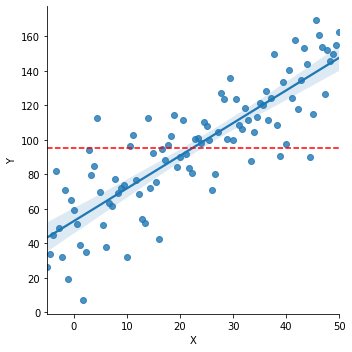

In [8]:
sns.lmplot(data=df, x='X', y='Y')
plt.axhline(df['Y'].mean(), color='r', ls='--')

In [9]:
y_bar = df['Y'].mean()
x_bar = df['X'].mean()
std_y = df['Y'].std()
std_x = df['X'].std()
r_xy = df.corr().loc['X','Y']
beta_1 = r_xy*(std_y/std_x)
beta_0 = y_bar - beta_1*x_bar

df['Linear_Yhat'] = beta_0 + beta_1*df['X']
MSE = np.square(df['Y'] - df['Linear_Yhat']).mean()
MSE

361.8134918217064

#### We now have our estimated line:

$$\hat{Y} = 51.38 + 2.032X$$

#### We can now plot our line

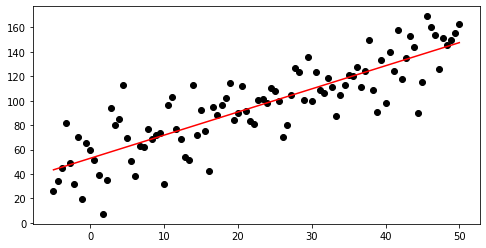

In [10]:
# create a figure
fig = plt.figure(figsize=(8,4))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(x, y, c='k')
ax.plot(df['X'], df['Linear_Yhat'], color='r')

#### We can also plot our residuals

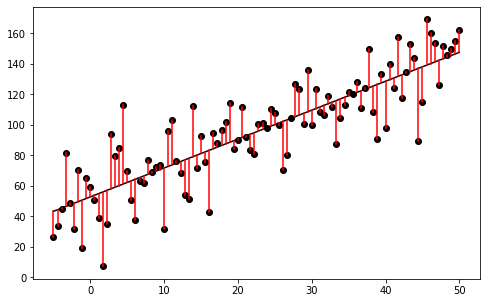

In [11]:
# create a figure
fig = plt.figure(figsize=(8,5))
# fig.set_figheight(8)
# fig.set_figwidth(15)

# get the axis
ax = fig.gca()

# plot it
ax.scatter(x=df['X'], y=df['Y'], c='k')
ax.plot(df['X'], df['Linear_Yhat'], color='k');

# iterate over predictions
for _, row in df.iterrows():
    plt.plot((row['X'], row['X']), (row['Y'], row['Linear_Yhat']), 'r-')

<a id="sacramento"></a>
## Example: Sacramento Real Estate Data
The dataset contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

%matplotlib inline

In [13]:
sac_csv = './datasets/Linear_Regression/sacramento.csv'

In [14]:
df_sac = pd.read_csv(sac_csv)
df_sac.head(2)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028


### 2. Conduct exploratory data analysis on this data set. 

**Report any notable findings here and any steps you take to clean/process data.**

> **Note:** These EDA checks should be done on every data set. If you find yourself checking for, say, missing/corrupted data over and over, it might be to your long-term benefit to have a function that you can re-use every time you're given some new data.

In [15]:
df_sac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [16]:
df_sac.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

In [17]:
df_sac.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

<AxesSubplot:>

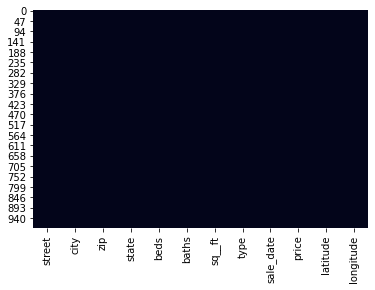

In [18]:
# looks like there are no missing values
sns.heatmap(df_sac.isnull(),cbar=False)

Zip code is better as a string object (categorical) so I we need to convert it.

In [19]:
df_sac['zip'] = df_sac['zip'].astype(str)

In [20]:
df_sac.describe()

,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,2.911675,1.776650,1312.918782,233715.951269,38.445121,-121.193371
std,1.307932,0.895371,856.123224,139088.818896,5.103637,5.100670
min,0.000000,0.000000,-984.000000,-210944.000000,-121.503471,-121.551704
25%,2.000000,1.000000,950.000000,145000.000000,38.482704,-121.446119
50%,3.000000,2.000000,1304.000000,213750.000000,38.625932,-121.375799
75%,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.294893
max,8.000000,5.000000,5822.000000,884790.000000,39.020808,38.668433


- Looks like we have some values that seem out of place being that there are
houses with 0 bedrooms, 0 baths, a negative sqr footage and a negative price.  
- There are also some bizarre longitudes/latitudes. A house in Antartica perhaps. 

In [21]:
df_sac.iloc[df_sac.loc[df_sac['sq__ft']==0].index]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
73,17 SERASPI CT,SACRAMENTO,95834,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,206000,38.631481,-121.501880
89,2866 KARITSA AVE,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,244500,38.626671,-121.525970
100,12209 CONSERVANCY WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,263500,38.553867,-121.219141
121,5337 DUSTY ROSE WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,320000,38.528575,-121.228600
126,2115 SMOKESTACK WAY,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,339500,38.602416,-121.542965
...,...,...,...,...,...,...,...,...,...,...,...,...
934,1550 TOPANGA LN Unit 207,LINCOLN,95648,CA,0,0,0,Condo,Thu May 15 00:00:00 EDT 2008,188000,38.884170,-121.270222
947,1525 PENNSYLVANIA AVE,WEST SACRAMENTO,95691,CA,0,0,0,Residential,Thu May 15 00:00:00 EDT 2008,200100,38.569943,-121.527539
966,9197 CORTINA CIR,ROSEVILLE,95678,CA,3,2,0,Condo,Thu May 15 00:00:00 EDT 2008,220000,38.793152,-121.290025
970,3557 SODA WAY,SACRAMENTO,95834,CA,0,0,0,Residential,Thu May 15 00:00:00 EDT 2008,224000,38.631026,-121.501879


In [22]:
df_sac[df_sac['beds'] == 0]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
73,17 SERASPI CT,SACRAMENTO,95834,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,206000,38.631481,-121.501880
89,2866 KARITSA AVE,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,244500,38.626671,-121.525970
100,12209 CONSERVANCY WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,263500,38.553867,-121.219141
121,5337 DUSTY ROSE WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,320000,38.528575,-121.228600
126,2115 SMOKESTACK WAY,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,339500,38.602416,-121.542965
...,...,...,...,...,...,...,...,...,...,...,...,...
901,1530 TOPANGA LN Unit 204,LINCOLN,95648,CA,0,0,0,Condo,Thu May 15 00:00:00 EDT 2008,138000,38.884150,-121.270277
917,501 POPLAR AVE,WEST SACRAMENTO,95691,CA,0,0,0,Residential,Thu May 15 00:00:00 EDT 2008,165000,38.584526,-121.534609
934,1550 TOPANGA LN Unit 207,LINCOLN,95648,CA,0,0,0,Condo,Thu May 15 00:00:00 EDT 2008,188000,38.884170,-121.270222
947,1525 PENNSYLVANIA AVE,WEST SACRAMENTO,95691,CA,0,0,0,Residential,Thu May 15 00:00:00 EDT 2008,200100,38.569943,-121.527539


Given the large value of houses that have 0 beds, 0 baths and 0 square feet, 
we can make an assumption that these are plots of land that have yet to have anything built on them. As a result they will *not* be dropped.

In [23]:
# dropping columns where sqft is zero

# clean_df=df_sac.drop(df_sac.loc[df['sq__ft']==0].index, axis=0)
# clean_df

In [24]:
df_sac.iloc[703]

street                   1900 DANBROOK DR
city                           SACRAMENTO
zip                                 95835
state                                  AC
beds                                    1
baths                                   1
sq__ft                               -984
type                                Condo
sale_date    Fri May 16 00:00:00 EDT 2008
price                             -210944
latitude                         -121.503
longitude                         38.6684
Name: 703, dtype: object

In [25]:
df_sac['sq__ft'].sort_values()

703    -984
492       0
559       0
558       0
557       0
       ... 
317    3992
535    4246
534    4303
864    4400
866    5822
Name: sq__ft, Length: 985, dtype: int64

In [26]:
# what about those houses that are less than 0 dollars?
df_sac[df_sac['price'] < 1]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
703,1900 DANBROOK DR,SACRAMENTO,95835,AC,1,1,-984,Condo,Fri May 16 00:00:00 EDT 2008,-210944,-121.503471,38.668433


In [27]:
# And the negative square feet?
df_sac[df_sac['sq__ft'] < 0]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
703,1900 DANBROOK DR,SACRAMENTO,95835,AC,1,1,-984,Condo,Fri May 16 00:00:00 EDT 2008,-210944,-121.503471,38.668433


Looks like the house with a negative price is also the one with a negative square feet. It is time to make a choice. Assume that the data was entered improperly and is meant to be positive or drop the data.

Side note, the state is actually labeled wrong as well.

In [28]:
# Let me check if any other values are also not labeled right.
df_sac[df_sac['state'] != 'CA']

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
703,1900 DANBROOK DR,SACRAMENTO,95835,AC,1,1,-984,Condo,Fri May 16 00:00:00 EDT 2008,-210944,-121.503471,38.668433


In [29]:
# Looks like it is just one row, so we can just drop it.

df_sac.drop(labels=703, inplace = True)

In [30]:
# df_sac[['beds', 'baths', 'sq__ft', 'price']] = df_sac[['beds', 'baths', 'sq__ft', 'price']].apply(lambda x: abs(x))

In [31]:
df_sac['sq__ft'].sort_values()

268       0
754       0
755       0
756       0
757       0
       ... 
317    3992
535    4246
534    4303
864    4400
866    5822
Name: sq__ft, Length: 984, dtype: int64

In [32]:
df_sac[df_sac['price'] < 1]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude


In [33]:
df_sac[df_sac['sq__ft'] < 0]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude


In [34]:
df_sac[df_sac['state'] != 'CA']

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude


### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in a SLR model. 

**For each of these variables you believe to be valid potential predictors in an SLR model, generate a plot showing the relationship between the independent variable and dependent variable.**

In [35]:
df_sac.columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'price', 'latitude', 'longitude'],
      dtype='object')

In [36]:
variables_that_qualify = ['price','beds', 'baths', 'sq__ft', 'type']

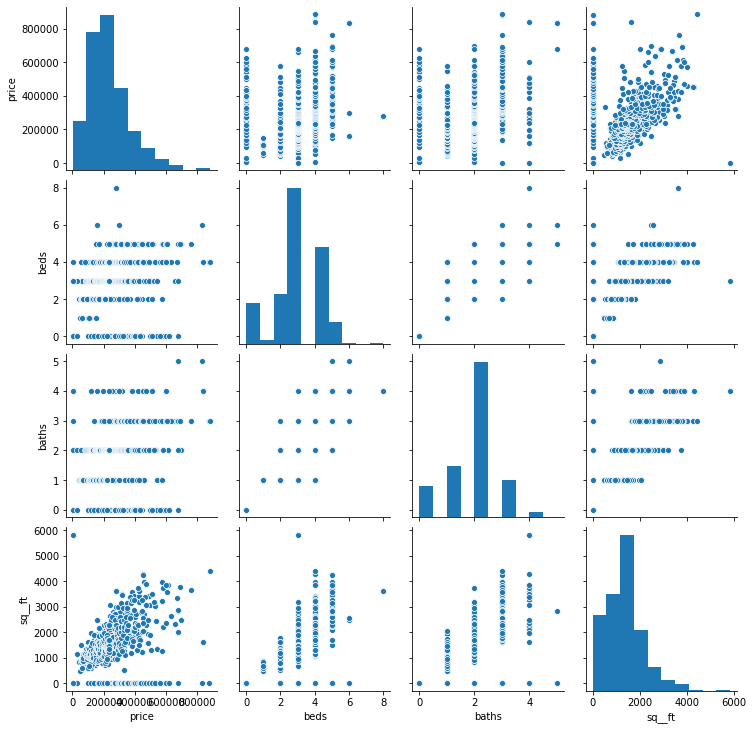

In [37]:
sns.pairplot(df_sac[variables_that_qualify])

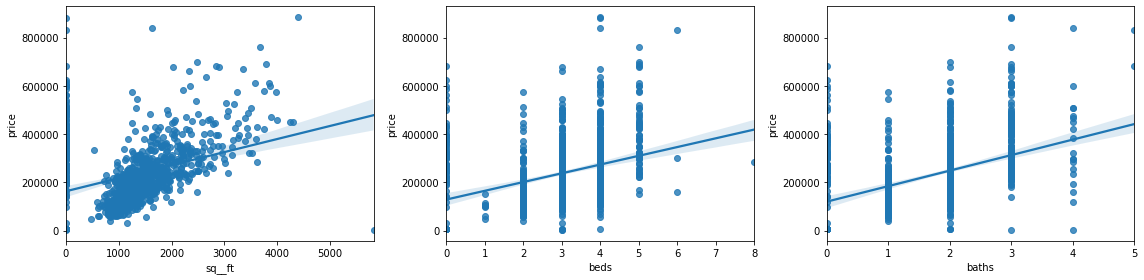

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

sns.regplot(x='sq__ft', y='price', data=df_sac, ax=axes[0])

sns.regplot(x='beds', y='price', data=df_sac, ax=axes[1])

sns.regplot(x='baths', y='price', data=df_sac, ax=axes[2])

plt.tight_layout()

### 4. Which variable would be the best predictor of Y in a SLR model? Why?

Square footage is usually the best predictor for a house. In this example, it looks like `sq_ft` is a better predictor than `beds` or `baths`. Beds and Baths are discrete measures as opposed to Square feet, which is continuous. Additionally, there is probably some strong coorelations between them in that houses with bigger square feet will have more beds and more baths.

If we dropped all the plots of land that are in the dataset (those with 0 sq ft, beds & baths) we would see a much stronger trend line in our lm plot.

### 5. Build a function that will take in two lists `Y` and `X` and returns the intercept and slope coefficients that minimize SSE. 

`Y` is the target variable and `X` is the predictor variable.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**

In [39]:
df_sac.head(1)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879


### $$ \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} \\
\hat{\beta}_1 = r_{XY} \frac{s_Y}{s_X}$$

In [40]:
np.corrcoef(x=df_sac['sq__ft'], y=df_sac['price'])

array([[1.        , 0.33386112],
       [0.33386112, 1.        ]])

In [41]:
np.corrcoef(x=df_sac['sq__ft'], y=df_sac['price'])[1][0]

0.3338611160372743

In [42]:
def funct(Y, X):
    x_bar = np.mean(X)
    y_bar = np.mean(Y)
    std_x = np.std(X)
    std_y = np.std(Y)
    p_corr = np.corrcoef(x=X, y=Y)[1][0]
    
    beta1 = p_corr * (std_y/std_x)
    
    intercept = y_bar - (beta1*x_bar)
    
    return intercept, beta1

funct(df_sac['price'], df_sac['sq__ft'])

(162938.73756098625, 54.15619752295767)

In [43]:
def simple_lin(X, Y):
    beta1 = np.corrcoef(x=X, y=Y)[1][0] * (np.std(Y)/np.std(X))
    beta0 = np.mean(Y) - (beta1 * np.mean(X))
    return beta0, beta1

simple_lin(df_sac['sq__ft'], df_sac['price'])

(162938.73756098625, 54.15619752295767)

In [44]:
import numpy as np
import scipy.stats as stats

# Get the optimal Slope and y intercept

def lin_reg(x,y):
    # Using other libraries for standard Deviation and Pearson Correlation Coef.
    # Note that in SLR, the correlation coefficient multiplied by the standard
    # deviation of y divided by standard deviation of x is the optimal slope.
    beta_1 = (stats.pearsonr(x,y)[0])*(np.std(y)/np.std(x))
    
    # Pearson Co. Coef returns a tuple so it needs to be sliced/indexed
    # the optimal beta is found by: mean(y) - b1 * mean(x)
    beta_0 = np.mean(y)-(beta_1*np.mean(x)) 
    
    #Print the Optimal Values
    print('The Optimal Y Intercept is ', beta_0)
    print('The Optimal slope is ', beta_1)

In [45]:
x = df_sac['sq__ft'].values
y = df_sac['price'].values
lin_reg(x,y)

The Optimal Y Intercept is  162938.73756098616
The Optimal slope is  54.15619752295773


<AxesSubplot:xlabel='sq__ft', ylabel='price'>

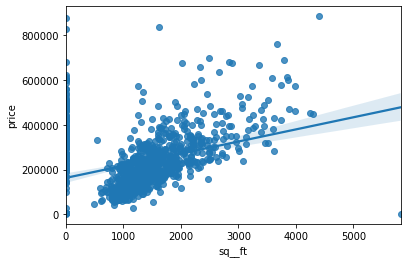

In [46]:
# sns.lmplot(data=df_sac, x='sq__ft', y='price')
sns.regplot(data=df_sac, x='sq__ft', y='price')

### 6. Interpret the intercept. Interpret the slope.

- **intercept** is the value of the house when sqft is zero.
- **slope** is the increase in price as a result of a 1 unit increase in sqft.

The intercept should be the relative y value that our data starts around in that from this point out, as x increase so should the y value from this point. The intercept is an "offset". Without the intercept our regression line would be forced to pass through the origin.

The slope is the increase in our target (price) variable for a 1-unit increase in our predictor variable (sq__ft). So, for every sq__ft increase there is an associated increase of roughly $54 dollars.

### 7. Give an example of how this model could be used for prediction and how this model could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

#### Prediction
You are a real estate agent with a separate database on house characteristics and locations. You want to estimate the most likely price that one of these houses will sell at based on the model that we built using this data.

#### Inference
You work for an architecture company that wants to understand what characteristics of a house and what areas are associated with perceived value. You have some hypotheses about what makes a house valuable but you would like to test these hypotheses. (For example, someone might want to know the effect on price from adding another bathroom.)

### 8: [Bonus] Using the model you came up with in Problem 5, calculate and plot the residuals.

In [47]:
# Y = beta0 + beta1*X

In [48]:
# errors = actual - predicted

In [49]:
beta0 = funct(df_sac['price'], df_sac['sq__ft'])[0]
beta1 = funct(df_sac['price'], df_sac['sq__ft'])[1]
print(beta0, beta1)

162938.73756098625 54.15619752295767


In [50]:
prediction = beta0 + (beta1 * df_sac['sq__ft'])
prediction

0      208213.318690
1      226139.020070
2      206047.070789
3      209079.817851
4      206101.226987
           ...      
980    286414.867913
981    242927.441302
982    228792.673749
983    254191.930387
984    236699.478587
Name: sq__ft, Length: 984, dtype: float64

In [51]:
df_sac['Predictions'] = prediction
df_sac['Residuals'] = df_sac['price'] - df_sac['Predictions']

# Residuals equals the difference between Y-True and Y-Pred
# df['Residuals'] = abs(df['price']-df['Predictions'])

df_sac.head(5)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,Predictions,Residuals
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,208213.318690,-148991.318690
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,226139.020070,-157927.020070
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,206047.070789,-137167.070789
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,209079.817851,-139772.817851
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,206101.226987,-124201.226987


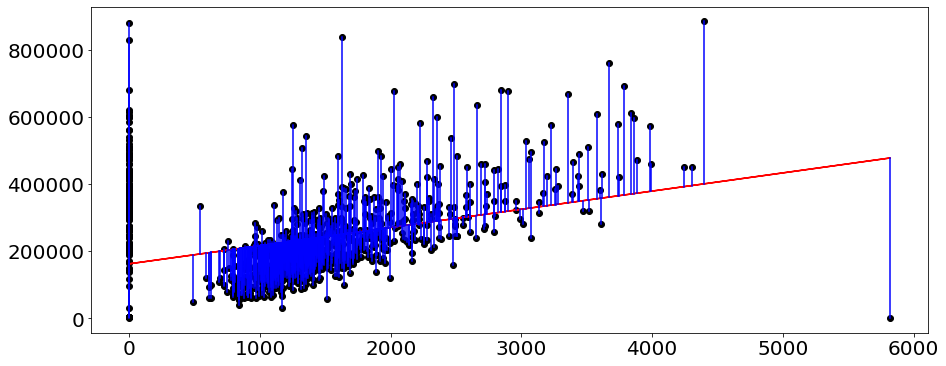

In [52]:
# Plot showing out linear forcast
fig = plt.figure(figsize=(15,6))

# change the fontsize of minor ticks label
plot = fig.add_subplot(111)
plot.tick_params(axis='both', which='major', labelsize=20)

# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(x= df_sac['sq__ft'], y=df_sac['price'], c='k')
ax.plot(df_sac['sq__ft'], df_sac['Predictions'], color='r')

# iterate over predictions
for _, row in df_sac.iterrows():
    plt.plot((row['sq__ft'], row['sq__ft']), (row['price'], row['Predictions']), 'b-')

In [53]:
def errors_viz(X,Y,df):
       
    # Plot showing out linear forcast
    fig = plt.figure(figsize=(15,6))

    # change the fontsize of minor ticks label
    plot = fig.add_subplot(111)
    plot.tick_params(axis='both', which='major', labelsize=20)

    # get the axis of that figure
    ax = plt.gca()

    # plot a scatter plot on it with our data
    ax.scatter(x=X, y=Y, c='k')
    ax.plot(X, df['Predictions'], color='r')

    # iterate over predictions
    for _, row in df.iterrows():
        plt.plot((row['sq__ft'], row['sq__ft']), (row['price'], row['Predictions']), 'b-')

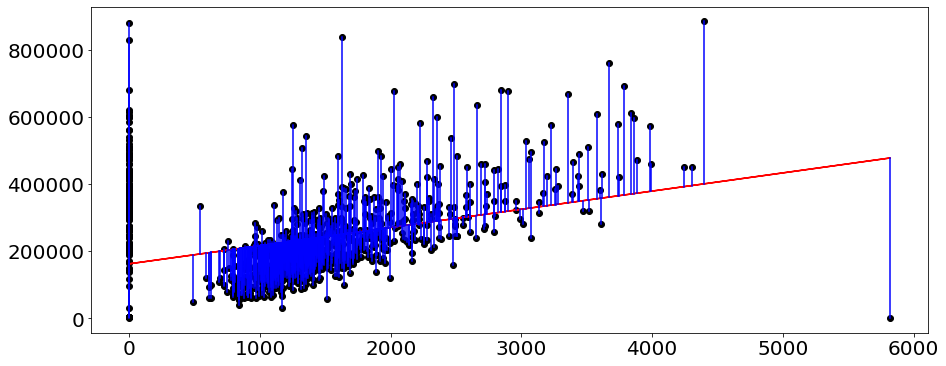

In [54]:
errors_viz(df_sac['sq__ft'], df_sac['price'],df_sac)

<AxesSubplot:xlabel='price', ylabel='Predictions'>

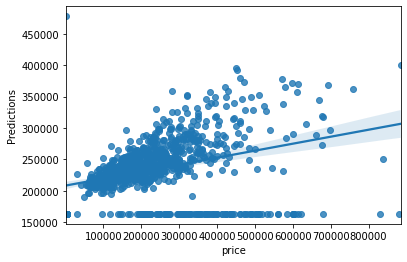

In [55]:
# One more plot, Lets look how our Predictions compared to the true values.
# sns.lmplot(x='price', y='Predictions', data=df_sac)
sns.regplot(x='price', y='Predictions', data=df_sac)

We can see that a lot of points were plotted along the y-intercept (y= 162938.74). Those were all the houses with a reported square footage of 0 feet.  We could probably create a more insightful model if we removed those observations from our data.

<a id="resource"></a>
## RESOURCES

https://people.duke.edu/~rnau/regintro.htm<br>
https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/<br>
https://adataanalyst.com/predictive-analysis/plotting-regression-line-in-python/<br>
https://www.hackdeploy.com/python-linear-regression-analysis/<br>
https://www.statology.org/residual-plot-python/<br>